In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

START_DATE = {
  'Japan': '1/22/20',
  'Italy': '1/31/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20'
}

class Learner(object):
    def __init__(self, country, loss):
        self.country = country
        self.loss = loss

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.country)
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        fig.savefig(f"{self.country}.png")

In [5]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

In [6]:
def main():

    countries, download, startdate, predict_range , s_0, i_0, r_0 = parse_arguments()

    if download:
        data_d = load_json("./data_url.json")
        download_data(data_d)

    sumCases_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
    sumCases_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
    sumCases_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')

    for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
        learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')
           

if __name__ == '__main__':
    main()

NameError: name 'parse_arguments' is not defined

In [7]:
import numpy as np
import pandas as pd
from csv import reader
from csv import writer
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import argparse
import sys
import json
import ssl
import urllib.request


def parse_arguments():
    parser = argparse.ArgumentParser()
    
    parser.add_argument(
        '--countries',
        action='store',
        dest='countries',
        help='Countries on CSV format. ' +
        'It must exact match the data names or you will get out of bonds error.',
        metavar='COUNTRY_CSV',
        type=str,
        default="")
    
    parser.add_argument(
        '--download-data',
        action='store_true',
        dest='download_data',
        help='Download fresh data and then run',
        default=False
    )

    parser.add_argument(
        '--start-date',
        required=False,
        action='store',
        dest='start_date',
        help='Start date on MM/DD/YY format ... I know ...' +
        'It defaults to first data available 1/22/20',
        metavar='START_DATE',
        type=str,
        default="1/22/20")

    parser.add_argument(
        '--prediction-days',
        required=False,
        dest='predict_range',
        help='Days to predict with the model. Defaults to 150',
        metavar='PREDICT_RANGE',
        type=int,
        default=150)

    parser.add_argument(
        '--S_0',
        required=False,
        dest='s_0',
        help='S_0. Defaults to 100000',
        metavar='S_0',
        type=int,
        default=100000)

    parser.add_argument(
        '--I_0',
        required=False,
        dest='i_0',
        help='I_0. Defaults to 2',
        metavar='I_0',
        type=int,
        default=2)

    parser.add_argument(
        '--R_0',
        required=False,
        dest='r_0',
        help='R_0. Defaults to 0',
        metavar='R_0',
        type=int,
        default=10)

    args = parser.parse_args()

    country_list = []
    if args.countries != "":
        try:
            countries_raw = args.countries
            country_list = countries_raw.split(",")
        except Exception:
            sys.exit("QUIT: countries parameter is not on CSV format")
    else:
        sys.exit("QUIT: You must pass a country list on CSV format.")

    return (country_list, args.download_data, args.start_date, args.predict_range, args.s_0, args.i_0, args.r_0)


def sumCases_province(input_file, output_file):
    with open(input_file, "r") as read_obj, open(output_file,'w',newline='') as write_obj:
        csv_reader = reader(read_obj)
        csv_writer = writer(write_obj)
               
        lines=[]
        for line in csv_reader:
            lines.append(line)    

        i=0
        ix=0
        for i in range(0,len(lines[:])-1):
            if lines[i][1]==lines[i+1][1]:
                if ix==0:
                    ix=i
                lines[ix][4:] = np.asfarray(lines[ix][4:],float)+np.asfarray(lines[i+1][4:] ,float)
            else:
                if not ix==0:
                    lines[ix][0]=""
                    csv_writer.writerow(lines[ix])
                    ix=0
                else:
                    csv_writer.writerow(lines[i])
            i+=1    


def download_data(url_dictionary):
    #Lets download the files
    for url_title in url_dictionary.keys():
        urllib.request.urlretrieve(url_dictionary[url_title], "./data/" + url_title)


def load_json(json_file_str):
    # Loads  JSON into a dictionary or quits the program if it cannot.
    try:
        with open(json_file_str, "r") as json_file:
            json_variable = json.load(json_file)
            return json_variable
    except Exception:
        sys.exit("Cannot open JSON file: " + json_file_str)


class Learner(object):
    def __init__(self, country, loss, start_date, predict_range,s_0, i_0, r_0):
        self.country = country
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0


    def load_confirmed(self, country):
        df = pd.read_csv('data/time_series_19-covid-Confirmed-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv('data/time_series_19-covid-Recovered-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv('data/time_series_19-covid-Deaths-country.csv')
        country_df = df[df['Country/Region'] == country]
        return country_df.iloc[0].loc[self.start_date:]
    

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, country, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        data = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2


def main():

    countries, download, startdate, predict_range , s_0, i_0, r_0 = parse_arguments()

    if download:
        data_d = load_json("./data_url.json")
        download_data(data_d)

    sumCases_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
    sumCases_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
    sumCases_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')

    for country in countries:
        learner = Learner(country, loss, startdate, predict_range, s_0, i_0, r_0)
        #try:
        learner.train()
        #except BaseException:
        #    print('WARNING: Problem processing ' + str(country) +
        #        '. Be sure it exists in the data exactly as you entry it.' +
        #        ' Also check date format if you passed it as parameter.')
           

if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--countries COUNTRY_CSV] [--download-data]
                             [--start-date START_DATE]
                             [--prediction-days PREDICT_RANGE] [--S_0 S_0]
                             [--I_0 I_0] [--R_0 R_0]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\COM\AppData\Roaming\jupyter\runtime\kernel-3c73489c-a6ff-49d0-be3c-e0f72e8cfd0a.json


SystemExit: 2

D:\Anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 10
    # variables        = 2
    chi-square         = 0.00505747
    reduced chi-square = 6.3218e-04
    Akaike info crit   = -71.8947443
    Bayesian info crit = -71.2895741
[[Variables]]
    x10:  5 (fixed)
    x20:  0 (fixed)
    x30:  0 (fixed)
    k0:   0.12183302 +/- 0.00590992 (4.85%) (init = 0.2)
    k1:   0.77583947 +/- 0.02663943 (3.43%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(k0, k1) =  0.809


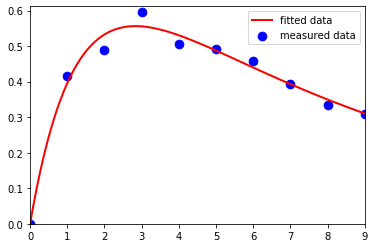

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint


def f(y, t, paras):
    """
    Your system of differential equations
    """

    x1 = y[0]
    x2 = y[1]
    x3 = y[2]

    try:
        k0 = paras['k0'].value
        k1 = paras['k1'].value

    except KeyError:
        k0, k1 = paras
    # the model equations
    f0 = -k0 * x1
    f1 = k0 * x1 - k1 * x2
    f2 = k1 * x2
    return [f0, f1, f2]


def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()


# initial conditions
x10 = 5.
x20 = 0
x30 = 0
y0 = [x10, x20, x30]

# measured data
t_measured = np.linspace(0, 9, 10)
x2_measured = np.array([0.000, 0.416, 0.489, 0.595, 0.506, 0.493, 0.458, 0.394, 0.335, 0.309])

plt.figure()
plt.scatter(t_measured, x2_measured, marker='o', color='b', label='measured data', s=75)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('k0', value=0.2, min=0.0001, max=2.)
params.add('k1', value=0.3, min=0.0001, max=2.)

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 9., 100), y0, result.params)

# plot fitted data
plt.plot(np.linspace(0., 9., 100), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

plt.show()